In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import maxwell, gaussian_kde
import astropy.constants as cons

# Maths
Two masses $m_1$ and $m_2$ are in binary. For $m_1$, the orbital velocity is $v_{orb,1}$ and period $P$. The separation between $m_1$ and $m_2$ is $a$.
$$
\frac{\mu v_{orb,1}^2}{a} = \frac{Gm_1m_2}{a^2}
$$
where $\mu$ is the reduced mass $\frac{m_1m_2}{m_1+m_2}$. Hence
$$
v_{orb,1}^2 = \frac{G(m_1+m_2)}{a} = \frac{Gm_1(1+Q)}{a} = \frac{G.(M_{\odot}\text{ in kg})}{(\text{AU in m})} \Big( \frac{m_1}{M_{\odot}} \Big) \Big( \frac{a}{AU} \Big)^{-1} (1+Q)
$$
$Q$ is the mass ratio $m_2/m_1$.

The kick velocity, $v_{kick}$ is assumed to be Maxellian with $\sigma_{kick}=265 km/s$ (consistent with Hobbs et al. 2005), and we compare it with $v_{orb}$.

In [2]:
def vorb_in_kmps(m1, Q, a):
    AU_to_m = 1.496e+11
    Solar_M_in_kg = 1.989e+30
    return ((cons.G.value*Solar_M_in_kg/AU_to_m) * m1 * (1+Q) / a)**0.5/1000

def vkick_in_kmps(ndraw, sigmakick=265):
    return maxwell(loc=0., scale=sigmakick).rvs(size=ndraw) # In km/s

# Primary Mass ($m_1$)
ZAMS mass follows Kroupa (written in $M_{\odot}$),
$$
m_{1,i} \sim \texttt{Kroupa}
$$
and we select only those $m_{1,i}$ which are in the bound $[6M_{\odot}, 20M_{\odot}]$ as this is the relevent range of neutron star formation with some uncertainty.

Post first mass-transfer,
$$
m_1 = f_{core}m_{1,i}
$$
with
$$
f_{core} = 0.35
$$

In [3]:
class PowerLawPDF(object): # Taken from https://github.com/farr/BumpCosmology/blob/main/src/scripts/mock_injections.py
    def __init__(self, alpha, a, b):
        assert alpha > 1

        self.alpha = alpha
        self.a = a
        self.b = b

        self.norm = (self.a - (self.a/self.b)**self.alpha*self.b)/(self.a*(self.alpha-1))

    def __call__(self, x):
        return (self.a/x)**self.alpha/self.a/self.norm
    
    def icdf(self, c):
        return ((self.a**self.alpha*self.b*c + self.a*self.b**self.alpha*(1-c))/(self.a*self.b)**self.alpha)**(1/(1-self.alpha))

rng = np.random.default_rng(333165393797366967556667466879860422123)
ndraw = 10**6

# Fourth Power Law of Kroupa IMF (Relevent for NS Formation)

powerlawindex = 2.7
mmin = 1.0 # In solar masses
mmax = 300.0
imfpdf = PowerLawPDF(powerlawindex, mmin, mmax) # Change it to something else for different imf.
m1i = imfpdf.icdf(rng.uniform(low=0, high=1, size=ndraw)) # Solar mass

mNSmin = 6.0
mNSmax = 20.0
m1i = m1i[m1i>mNSmin]
m1i = m1i[m1i<mNSmax]

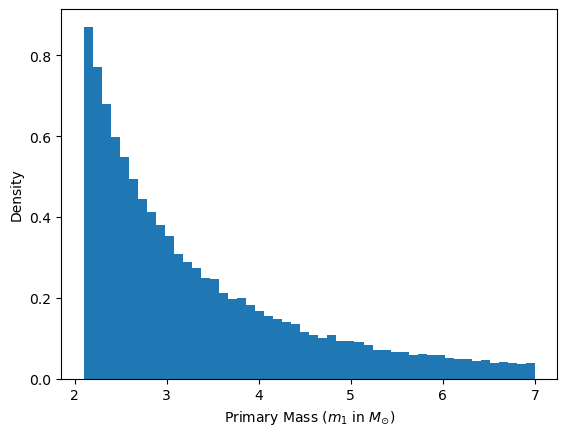

In [4]:
fcore = 0.35
m1 = fcore*m1i
_ = plt.hist(m1, bins=50, density=True)
plt.xlabel(r'Primary Mass ($m_1$ in $M_{\odot}$)')
plt.ylabel('Density');

ndraw = m1.shape[0]

# Mass Ratio
ZAMS mass ratio follows uniform distribution (the lower bound is set to $0.01$ such that secondary ZAMS mass is $0.01M_{\odot}$),
$$
Q_i \sim \texttt{Uniform}(0.01, 1)
$$
Post first mass-transfer,
$$
Q = \frac{m_{2,i}+\beta m_{1,i}(1-f_{core})}{f_{core}m_{1,i}} = \frac{Q_i+\beta(1-f_{core})}{f_{core}}
$$
$\beta$ is the mass transfer efficiency. We fix $\beta=0.5$.

NOTE: We define $Q_i<1$. During the mass-transfer it can be greater $1$, as we already defined primary mass and secondary mass in ZAMS phase.

In [5]:
Qi = np.random.uniform(0.01, 1.0, size=ndraw)

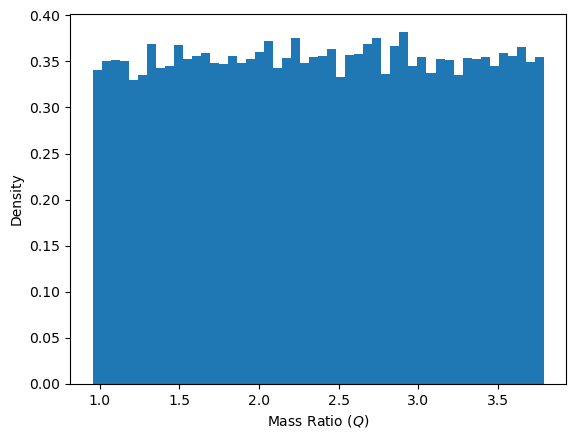

In [6]:
beta = 0.5
Q = (Qi+beta*(1-fcore))/fcore

_ = plt.hist(Q, bins=50, density=True)
plt.xlabel(r'Mass Ratio ($Q$)')
plt.ylabel('Density');

# Separation ($a$):
In ZAMS phase, logarithm of separtion is uniform,
$$
\log a_i \sim \texttt{Uniform}(\log 0.01, \log 1000)
$$
Post first transfer,
$$
a = \frac{a_i}{f_{core}^2}\Big( \frac{Q+1}{f_{core}Q+1} \Big)exp(2Q(f_{core}-1))
$$

In [7]:
logai = rng.uniform(low=np.log(0.01), high=np.log(1000), size=ndraw) # AU
ai = np.exp(logai)

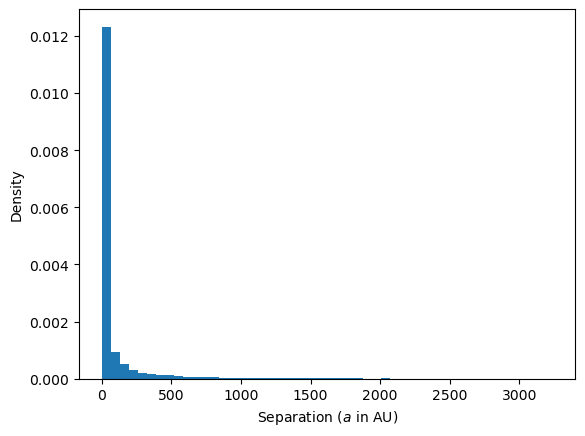

In [8]:
a = ai*(1/fcore**2)*((Q+1)/(fcore*Q+1))*np.exp(2*Q*(fcore-1))

_ = plt.hist(a, bins=50, density=True)
plt.xlabel(r'Separation ($a$ in AU)')
plt.ylabel('Density');

In [9]:
vorb = vorb_in_kmps(m1, Q, a)
vkick = vkick_in_kmps(ndraw)

Text(0, 0.5, 'Population Density')

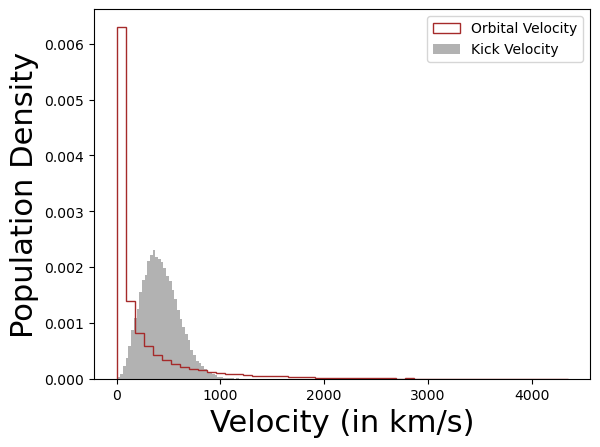

In [10]:
_ = plt.hist(vorb, bins=50, histtype='step', density=True, color='brown', label='Orbital Velocity')
_ = plt.hist(vkick, bins=50, density=True, color='grey', alpha=0.6, label='Kick Velocity')
plt.legend()
plt.xlabel(r'Velocity (in km/s)', fontsize=22)
plt.ylabel(r'Population Density', fontsize=22)

To check $v_{orb}<v_{kick}$, we define:
$$
x = v_{kick} - v_{orb}
$$
and check at what confidence $x>0$.

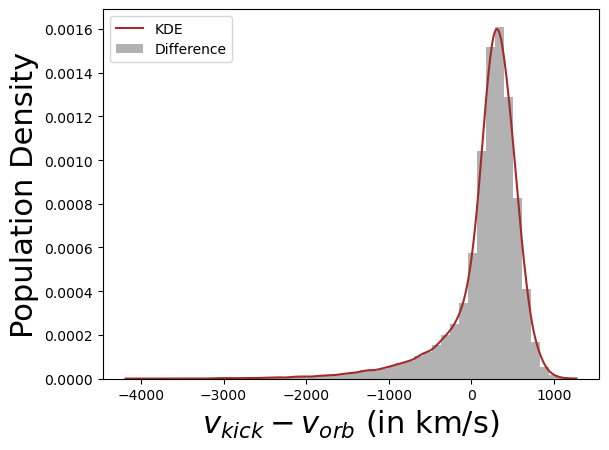

In [11]:
x = vkick - vorb
kernel = gaussian_kde(x)

plt.plot(np.sort(x), kernel.pdf(np.sort(x)), color='brown', label='KDE')
_ = plt.hist(x, bins=50, density=True, color='grey', alpha=0.6, label='Difference')
plt.legend()
plt.xlabel(r'$v_{kick}-v_{orb}$ (in km/s)', fontsize=22)
plt.ylabel(r'Population Density', fontsize=22);

In [12]:
prob = kernel.integrate_box_1d(low=0, high=1000)
print('Probability of vkick>vorb:', prob*100, '%')

Probability of vkick>vorb: 79.67302257633393 %


# Hence $v_{kick}>v_{orb}$ 80% of the times.

In [13]:
ndraw

41384